# Challenge 1
Elaboró: Leon Palomares

Grupo: 2

Matricula: 325057406

In [17]:
import os, sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"

## Iniciamos Sesión Spark

In [18]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("Challenge_1")
    .config("spark.executorEnv.PYSPARK_PYTHON", sys.executable)
    .config("spark.executorEnv.PYARROW_IGNORE_TIMEZONE", "1")
    .config("spark.sql.session.timeZone", "UTC")
    .getOrCreate()
)
print("Spark Version:", spark.version)

Spark Version: 3.5.6


### Importamos Librerias

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as f
import pyspark.pandas as ps  # pandas-on-Spark (antes Koalas)
import plotly.express as px

### Importamos BD

In [20]:
kdf = ps.read_csv("globalterrorismdb_0718dist.csv")
kdf.info()

c:\Users\yeste\anaconda3\envs\GBD\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 181691 entries, 0 to 181690
Data columns (total 135 columns):
 #    Column              Non-Null Count   Dtype  
---   ------              --------------   -----  
 0    eventid             181691 non-null  int64  
 1    iyear               181691 non-null  int32  
 2    imonth              181691 non-null  int32  
 3    iday                181691 non-null  int32  
 4    approxdate          9239 non-null    object 
 5    extended            181691 non-null  int32  
 6    resolution          2220 non-null    object 
 7    country             181691 non-null  int32  
 8    country_txt         181691 non-null  object 
 9    region              181691 non-null  int32  
 10   region_txt          181691 non-null  object 
 11   provstate           181270 non-null  object 
 12   city                181257 non-null  object 
 13   latitude            177135 non-null  float64
 14   longitude           177134 non-null  float64
 15   specificity 

Renombramos Columnas para simplificar

In [21]:
colnames = {
    'iyear': 'Year', 
    'imonth': 'Month',
    'iday': 'Day',
    'country_txt': 'Country',
    'region_txt': 'Region',
    'city': 'City',
    'attacktype1_txt': 'AttackType',
    'targtype1_txt': 'TargetType',
    'gname': 'Group',
    'weaptype1_txt': 'WeaponType',
    'nkill': 'Killed',
    'nwound': 'Wounded'
}

# Aplicar el renombramiento usando Koalas/pyspark.pandas
kdf_cleaned = kdf.rename(columns=colnames)

# Seleccionar solo las columnas renombradas para simplificar
kdf1 = kdf_cleaned[list(colnames.values())]

kdf1['Killed'] = kdf1['Killed'].astype(np.int32)
kdf1['Wounded'] = kdf1['Wounded'].astype(np.int32)

Obtenemos una descripcion de los datos


In [22]:
kdf1.head(5)

,Year,Month,Day,Country,Region,City,AttackType,TargetType,Group,WeaponType,Killed,Wounded
0,1970,7,2,Dominican Republic,Central America & Caribbean,Santo Domingo,Assassination,Private Citizens & Property,MANO-D,Unknown,1.0,0.0
1,1970,0,0,Mexico,North America,Mexico city,Hostage Taking (Kidnapping),Government (Diplomatic),23rd of September Communist League,Unknown,0.0,0.0
2,1970,1,0,Philippines,Southeast Asia,Unknown,Assassination,Journalists & Media,Unknown,Unknown,1.0,0.0
3,1970,1,0,Greece,Western Europe,Athens,Bombing/Explosion,Government (Diplomatic),Unknown,Explosives,NaN,NaN
4,1970,1,0,Japan,East Asia,Fukouka,Facility/Infrastructure Attack,Government (Diplomatic),Unknown,Incendiary,NaN,NaN


In [23]:
kdf1.describe()

,Year,Month,Day,Killed,Wounded
count,181691.000000,181691.000000,181691.000000,170617.000000,165251.000000
mean,2002.638997,6.467277,15.505644,2.403823,3.152634
std,13.259430,3.388303,8.814045,11.554776,35.939636
min,1970.000000,0.000000,0.000000,-9.000000,0.000000
25%,1991.000000,4.000000,8.000000,0.000000,0.000000
50%,2009.000000,6.000000,15.000000,0.000000,0.000000
75%,2014.000000,9.000000,23.000000,2.000000,2.000000
max,2017.000000,12.000000,31.000000,1570.000000,8191.000000


Gestionamos los valores nulos. En el caso de las categorias de interes, los cambiamos por 0.

In [24]:
kdf1['Killed'] = kdf1['Killed'].astype(np.int32)
kdf1['Wounded'] = kdf1['Wounded'].astype(np.int32)

# Conteo de valores nulos por columna
total_rows = len(kdf1)
null_counts = kdf1.isnull().sum()
null_percentage = (null_counts / total_rows) * 100
nulls = ps.concat([null_counts.rename("nulos"), null_percentage.rename("porcentaje")], axis=1)
nulls[nulls['nulos'] > 0]

,nulos,porcentaje
City,434,0.238867
AttackType,35,0.019263
TargetType,263,0.144751
Group,487,0.268037
WeaponType,436,0.239968
Killed,11074,6.094963
Wounded,16440,9.048329


Visualizamos los datos

c:\Users\yeste\anaconda3\envs\GBD\lib\site-packages\pyspark\pandas\groupby.py:893: FutureWarning: Default value of `numeric_only` will be changed to `False` instead of `True` in 4.0.0.
  warnings.warn(
c:\Users\yeste\anaconda3\envs\GBD\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


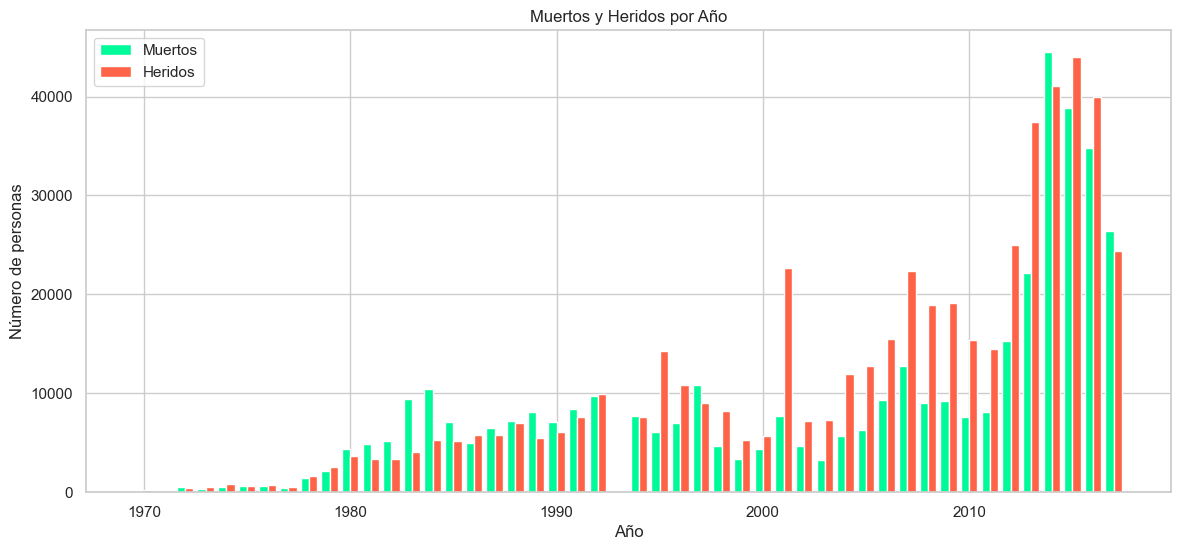

In [25]:
df_yearly = kdf1.groupby('Year')[['Killed', 'Wounded']].sum().reset_index()

df_yearly_pd = df_yearly.to_pandas()

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(df_yearly_pd['Year'] - 0.2, df_yearly_pd['Killed'], width=0.4, color='mediumspringgreen', label='Muertos')
ax.bar(df_yearly_pd['Year'] + 0.2, df_yearly_pd['Wounded'], width=0.4, color='tomato', label='Heridos')

ax.set_xlabel('Año')
ax.set_ylabel('Número de personas')
ax.set_title('Muertos y Heridos por Año')
ax.legend()

plt.show()


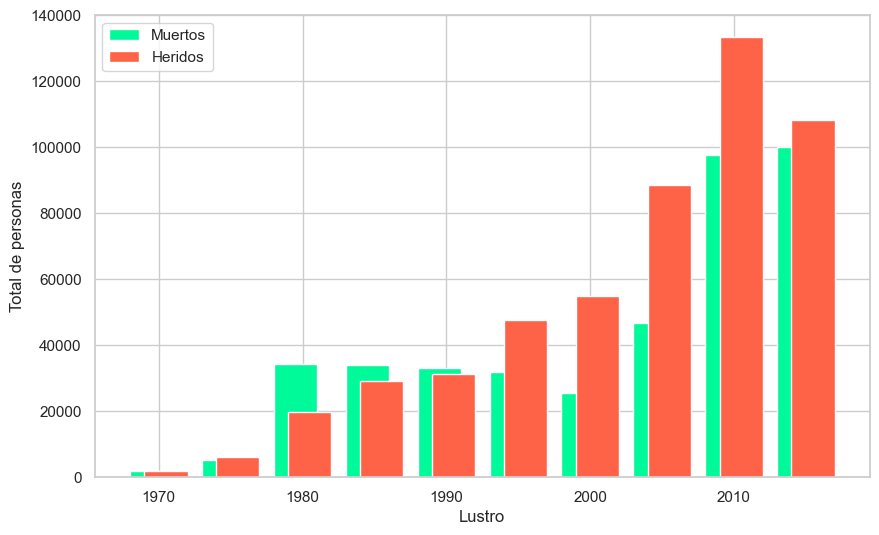

In [26]:
kdf1['Lustro'] = (kdf1['Year'] // 5) * 5
df_grouped = kdf1.groupby('Lustro')[['Killed', 'Wounded']].sum().reset_index()

df_grouped_pd = df_grouped.to_pandas()

# Graficar
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(df_grouped_pd['Lustro'] - 0.5, df_grouped_pd['Killed'], width=3, color='mediumspringgreen', label='Muertos')
ax.bar(df_grouped_pd['Lustro'] + 0.5, df_grouped_pd['Wounded'], width=3, color='tomato', label='Heridos')
ax.set_xlabel('Lustro')
ax.set_ylabel('Total de personas')
ax.legend()
plt.show()

c:\Users\yeste\anaconda3\envs\GBD\lib\site-packages\pyspark\pandas\base.py:1437: FutureWarning:

The resulting Series will have a fixed name of 'count' from 4.0.0.

c:\Users\yeste\anaconda3\envs\GBD\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.



Text(0.5, 1.0, 'Top 10 Países con Mayor Número de Incidentes')

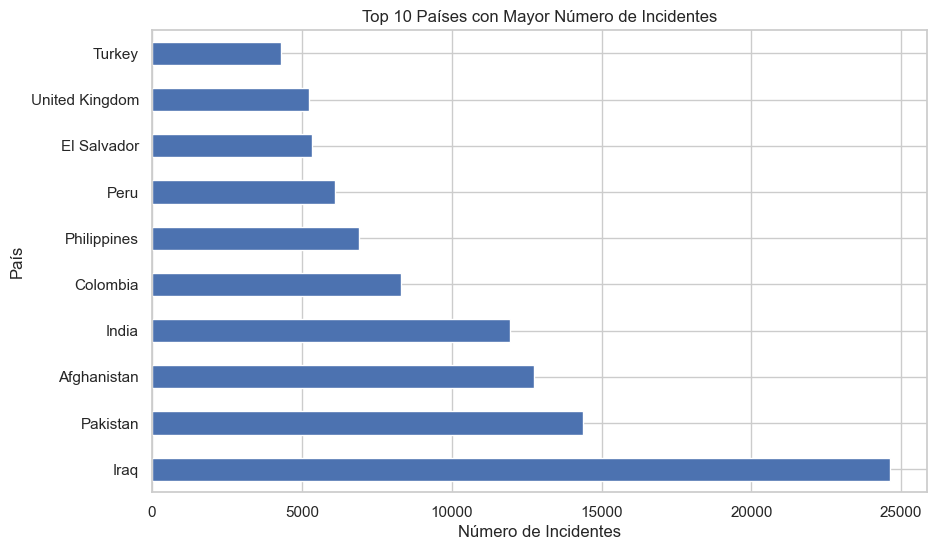

In [36]:
kdf2 = kdf1['Country'].value_counts().head(10)
ax = kdf2.to_pandas().plot(kind='barh', figsize=(10, 6))
ax.set_xlabel("Número de Incidentes")
ax.set_ylabel("País")
ax.set_title("Top 10 Países con Mayor Número de Incidentes")

In [37]:
kdf1['Country'].value_counts().tail(15)

c:\Users\yeste\anaconda3\envs\GBD\lib\site-packages\pyspark\pandas\base.py:1437: FutureWarning:

The resulting Series will have a fixed name of 'count' from 4.0.0.



Equatorial Guinea      2
Mauritius              2
St. Kitts and Nevis    2
Turkmenistan           2
Vanuatu                2
New Hebrides           1
Andorra                1
South Vietnam          1
Falkland Islands       1
Vatican City           1
North Korea            1
Wallis and Futuna      1
Antigua and Barbuda    1
International          1
St. Lucia              1
Name: Country, dtype: int64

c:\Users\yeste\anaconda3\envs\GBD\lib\site-packages\pyspark\pandas\groupby.py:893: FutureWarning:

Default value of `numeric_only` will be changed to `False` instead of `True` in 4.0.0.

c:\Users\yeste\anaconda3\envs\GBD\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



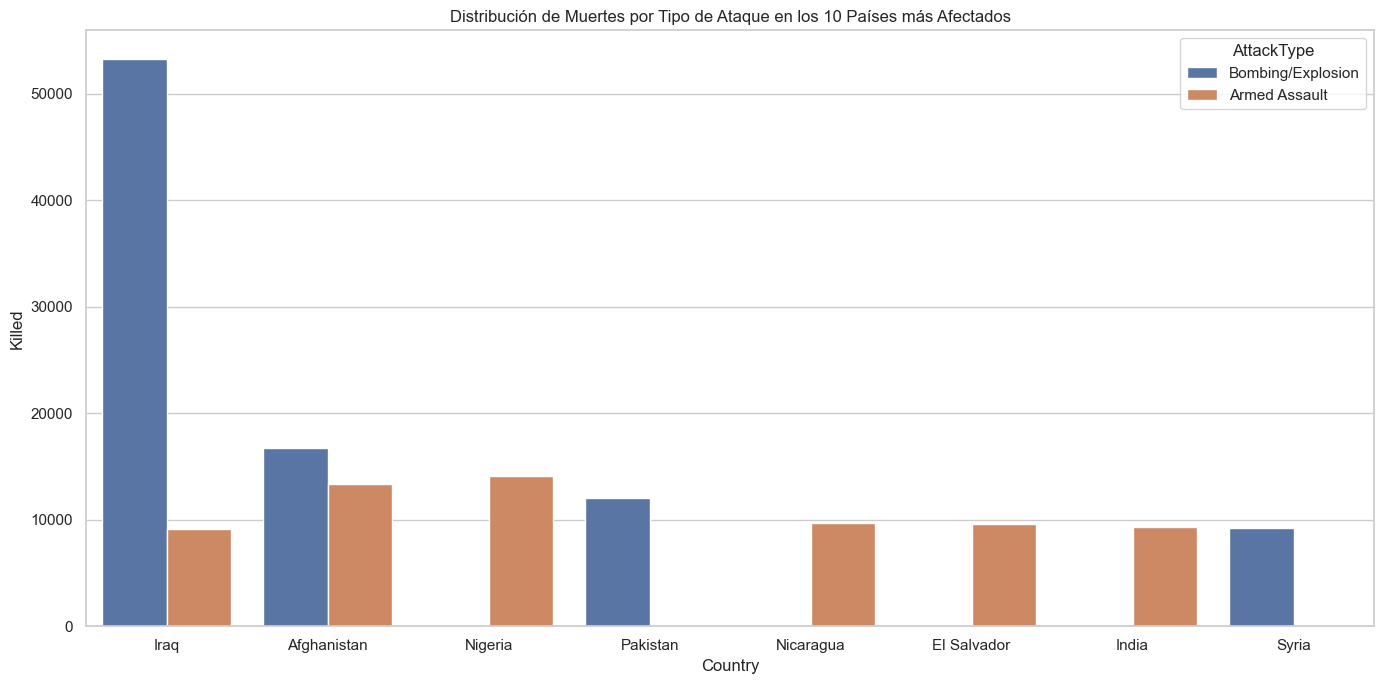

In [39]:
df_grouped = kdf1.groupby(['Country', 'AttackType'])['Killed'].sum().reset_index()

# Ordenar por número de muertes descendente
df_top10 = df_grouped.sort_values(by='Killed', ascending=False).head(10)
df_top10_pd = df_top10.to_pandas()

sns.set(style="whitegrid")

plt.figure(figsize=(14,7))
sns.barplot(data=df_top10_pd, x='Country', y='Killed', hue='AttackType')
plt.title('Distribución de Muertes por Tipo de Ataque en los 10 Países más Afectados')
plt.tight_layout()
plt.show()

Detenemos la sesión Spark

In [ ]:
# Parar la sesión de Spark
spark.stop()